# Imports

In [8]:
!pwd
import os
import shutil
import matplotlib.pyplot as plt
import pandas

from molgroups.support import molstat
from molgroups.infotheory import entropy

# always use the same testdata
shutil.copyfile('./bu/sim.dat', os.getcwd()+'/sim.dat')

'pwd' is not recognized as an internal or external command,
operable program or batch file.


'C:\\Users\\Frank Heinrich\\PycharmProjects\\molgroups\\examples\\information_theory\\experimental_optimization\\SANS\\EllipsoidProtein_SingleDataset_CuvetteThickness/sim.dat'

# Variables for example fit and optimization

In [9]:
# Run Optimization or only example fit and data simulation
RunFit=True
RunOptimization=True

# Folders and fit application
store = "T"
setupdir = os.getcwd()
runfile = "run"
fitsource = "SASView"

# MCMC fit iterations in example fit and optimization
burn=5000
steps=500

# enforced qmin and qmax, even if detector would cover larger q-range
# alternatively: take enforced q-range from first provided data file (index 0)
# set total counting time for the entire experiment (in s), or None
# number of gpcam iterations, if gpcam is used
qmin = 0.001
qmax = 0.8
qrangefromfile = False
t_total = None
optimizer = 'grid'  # optimizer can be 'grid' or gpcam
fitter = 'MCMC'  # fit driver for optimization either 'MCMC' or 'LM'
remove_fit_dir = False # Keep fit directories for inspection of individual simulated fits

# only used for gpcam optimizer
gpcam_iterations = 1200
gpcam_init_dataset_size = 200  # usually 20
gpcam_step = 10                # at least 2 to make use of local and global optimization
# Acquisition Functions. Use "variance" for pure exploration, 'maximum' to zero in on an already identified information gain maximum, 'ucb' for an exploration-exploitation balance, and 'shannon_ig_vec' for a maximization in information gain.
acq_func='ucb'

# only used for grid optimizer
convergence = 2.0           # convergence criteria for internal robustness check
miniter = 1                # minimum number of samples per grid point, chose at least 2 for error bars
bcalcsymmetric = True       # if problem is symmetric in variable parameters, should symmetric solutions be calculated twice?

# isotropic scattering background
# user-defined linear relationship between a SLD of the bulk solvent and the differential macroscopic scattering crosssection of the buffer
#cross_section_background = {'slope':-0.1626, 'y_intercept': 0.7980}  # acetonitrile
#mode = 'SANS_linear'
# presets for water
mode = 'water'
cross_section_background = None

# Prepare gpcam to keep plots for individual iterations and make fine enough steps between record keeping. Useful for constructing a movie.
# If not needed, set keep_plots to False, init dataset size to 20, do not show support points, and set gpcam steps to None
keep_plots = False
show_support_points = False

## misc entropy setup
bClusterMode = False
bFetchMode = False
time = 2
upper_info_plotlevel = None
plotlimits_filename = ""
calcsingle = False

# setup batchscript for SLURM (if used)
script = ['#!/bin/bash\n',
          '#SBATCH --job-name=entro {mcmc_iteration}\n',
          '#SBATCH -A mc4s9np\n', '#SBATCH -p RM\n',
          '#SBATCH -t 0' + str(time) + ':00:00\n',
          '#SBATCH -N 4\n', '#SBATCH --ntasks-per-node 28\n',
          '\n',
          'set +x\n',
          'cd $SLURM_SUBMIT_DIR\n',
          '\n',
          'module load python/2.7.11_gcc\n',
          'export PYTHONPATH=/home/hoogerhe/bin/lib/python2.7/site-packages:/home/hoogerhe/src/bumps\n',
          '\n',
          'mpirun -np 112 python /home/hoogerhe/src/refl1d/bin/refl1d_cli.py {mcmc_dirname}/run.py --fit=dream --mpi --init=lhs --batch --pop=28 --time='
          + str(float(time) - 0.1) + ' --thin=20 --store={mcmc_dirname}/save --burn=' + str(burn)
          + ' --steps=' + str(steps) + '\n'
          ]
# script.append('cd '+dirname+'\n')

# Create Short Example Fit

1.  The model needs to define fittable parameters with unique names, as shown below. For example, model0.scale and model1.scale would not be unique, since both parameters would be internally named 'scale' by bumps. In such a case, define parameters using the Parameter method and assign them to the models afterwards.

In [10]:
%%writefile run.py
from bumps.names import *
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data

# IMPORT THE DATA USED
data = load_data('sim.dat')

#setattr(data, 'qmin', 0.01)
#setattr(data, 'qmax', 10.0)

# DEFINE THE MODEL
kernel = load_model('ellipsoid@hayter_msa')

pars = dict(scale=1.0, background=0.0005, sld=3.4, sld_solvent=6.4, radius_polar=14.0,
            radius_equatorial=12.0, volfraction=0.075, charge=5, temperature=298.0,
            concentration_salt=0.150, dielectconst=71.08)

model = Model(kernel, **pars)

# PARAMETER RANGES (ONLY THOSE PARAMETERS ARE FITTED)
# model.scale.range(0.1, 7.)
# model.background.range(0, 1)
# model.sld.range(-2, 10)
# model.sld_solvent.range(0, 5)
model.radius_polar.range(17, 35)
model.radius_equatorial.range(5, 17)
model.volfraction.range(0.0001,0.02)
# model.charge.range(0, 20)
# model.temperature.range(0, 1000)
# model.concentration_salt.range(0, 1)
# model.dielectconst.range(0,100)

M = Experiment(data=data, model=model)
problem = FitProblem(M)

Overwriting run.py


# Run Example Fit

In [11]:
fitobj = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=None,
    problem=None,
)

if RunFit:
    # remove store directory if it already exists, since we do not want to reload here
    if os.path.isdir(os.path.join(setupdir, store)):
        shutil.rmtree(os.path.join(setupdir, store))
    fitobj.Interactor.fnRunMCMC(burn, steps, batch=False)

fitobj.fnRestoreFit()

# steps: 100, # draws: 3000
step 1 cost 6.427(16)
                       radius_equatorial ...|......    8.61505 in (5,17)
                            radius_polar ......|...    28.3195 in (17,35)
                             volfraction ..|....... 0.00426874 in (0.0001,0.02)
step 134 cost 0.690(16)
step 269 cost 0.683(16)
step 405 cost 0.682(16)
step 541 cost 0.682(16)
step 678 cost 0.682(16)
.background = 0.0005
.charge = 5
.concentration_salt = 0.15
.dielectconst = 71.08
.phi = 60
.phi_pd = 0
.phi_pd_n = 35
.phi_pd_nsigma = 3
.radius_effective = 20.75
.radius_effective_mode = 1
.radius_effective_pd = 0
.radius_effective_pd_n = 35
.radius_effective_pd_nsigma = 3
.radius_equatorial = 13.0967 in [5,17]
.radius_equatorial_pd = 0
.radius_equatorial_pd_n = 35
.radius_equatorial_pd_nsigma = 3
.radius_polar = 25.2875 in [17,35]
.radius_polar_pd = 0
.radius_polar_pd_n = 35
.radius_polar_pd_nsigma = 3
.scale = 1
.sld = 3.4
.sld_M0 = 0
.sld_mphi = 0
.sld_mtheta = 0
.sld_solvent = 6.4
.sld_solv

## Test Data Simulation
### 1. Show Best-fit parameters from above fit

In [5]:
df = pandas.read_csv(os.path.join(setupdir, store, runfile+'.par'), sep='\s+', header=None, names=['Parameter', 'Fit Value'])
df

,Parameter,Fit Value
0,radius_equatorial,13.099180
1,radius_polar,25.385479
2,volfraction,0.002133


2. Define simulation model parameters. They are written out to simpar.dat. Please change to desired values or copy from dataframe above.

In [6]:
%%writefile simpar.dat
radius_equatorial 13.094
radius_polar  25.359
volfraction  0.002137

Overwriting simpar.dat


3. Define Instrument configurations. Each dataset can have its own instrument configuration. In the example below, a single configuration is assigned to all datasets. The configuration is made of three settings with different sample-detector distances.

In [7]:
sb = 0.059
configuration_dataset1 = [{'lambda': 6.21,
                            "sample_detector_distance": 100,
                            'source_sample_distance': 387.6,
                            'source_aperture_radius':5.08*0.5,
                            'sample_aperture_radius':1.27*0.5,
                            "beamstop_diameter": 10.16,
                            "neutron_flux": 5e4,
                            'time': 1600,
                            'beam_center_x': 25,
                            "dlambda_lambda":0.136,
                            "differential_cross_section_buffer": sb},
                          {'lambda': 6.21,
                           "sample_detector_distance": 400,
                           'source_sample_distance': 850.05,
                           'source_aperture_radius':5.08*0.5,
                           'sample_aperture_radius':1.27*0.5,
                           "beamstop_diameter": 10.16,
                           "neutron_flux": 4e4,
                           'time': 3600,
                           "dlambda_lambda":0.136,
                           "differential_cross_section_buffer": sb},
                         {'lambda': 6.21,
                          "sample_detector_distance": 1300,
                          'source_sample_distance': 1467,
                          'source_aperture_radius':5.08*0.5,
                          'sample_aperture_radius':1.27*0.5,
                          "dlambda_lambda":0.136,
                          "beamstop_diameter": 10.16,
                          "neutron_flux": 4e4,
                          'time': 4400,
                          "differential_cross_section_buffer": sb}]

configuration = [configuration_dataset1]

4. Visually check configuration.

In [8]:
df = pandas.DataFrame.from_dict(configuration_dataset1)
df

,lambda,sample_detector_distance,source_sample_distance,source_aperture_radius,sample_aperture_radius,beamstop_diameter,neutron_flux,time,beam_center_x,dlambda_lambda,differential_cross_section_buffer
0,6.21,100,387.60,2.54,0.635,10.16,50000.0,1600,25.0,0.136,0.059
1,6.21,400,850.05,2.54,0.635,10.16,40000.0,3600,NaN,0.136,0.059
2,6.21,1300,1467.00,2.54,0.635,10.16,40000.0,4400,NaN,0.136,0.059


5. Simulate data.

In [9]:
fitobj.fnSimulateData(basefilename='sim.dat', liConfigurations=configuration, qmin=qmin, qmax=qmax, t_total=None)

                 par      value
0  radius_equatorial  13.094000
1       radius_polar  25.359000
2        volfraction   0.002137
[[{'lambda': 6.21, 'sample_detector_distance': 100, 'source_sample_distance': 387.6, 'source_aperture_radius': 2.54, 'sample_aperture_radius': 0.635, 'beamstop_diameter': 10.16, 'neutron_flux': 50000.0, 'time': 1600, 'beam_center_x': 25, 'dlambda_lambda': 0.136, 'differential_cross_section_buffer': 0.059}, {'lambda': 6.21, 'sample_detector_distance': 400, 'source_sample_distance': 850.05, 'source_aperture_radius': 2.54, 'sample_aperture_radius': 0.635, 'beamstop_diameter': 10.16, 'neutron_flux': 40000.0, 'time': 3600, 'dlambda_lambda': 0.136, 'differential_cross_section_buffer': 0.059}, {'lambda': 6.21, 'sample_detector_distance': 1300, 'source_sample_distance': 1467, 'source_aperture_radius': 2.54, 'sample_aperture_radius': 0.635, 'dlambda_lambda': 0.136, 'beamstop_diameter': 10.16, 'neutron_flux': 40000.0, 'time': 4400, 'differential_cross_section_buffer': 0

/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: invalid value encountered in divide
  return (self.theory() - self.Iq) / self.dIq


### Compare original and simulated data.
1. Compare Data

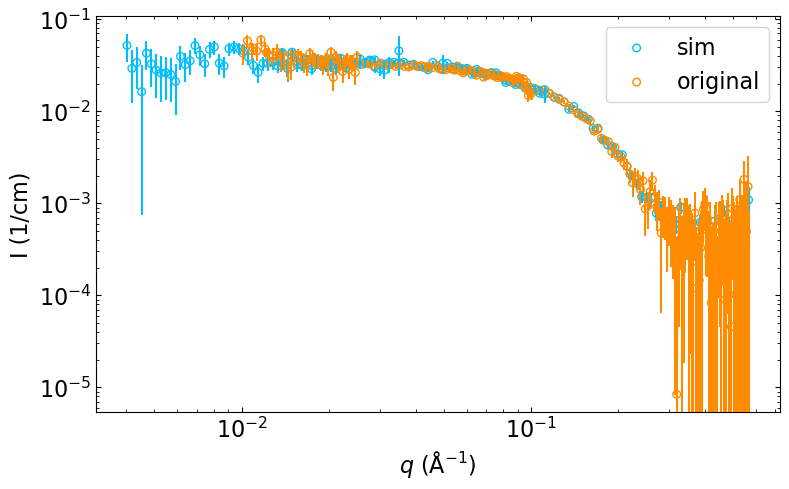

In [10]:
import pandas

fig, ax = plt.subplots()

original = pandas.read_csv('bu/sim.dat', sep=' ', skip_blank_lines=True,comment='#')
simdata = pandas.read_csv('sim.dat', sep=' ', skip_blank_lines=True,comment='#')

ax.errorbar(simdata['Q'], simdata['I'], simdata['dI'], ls='none', color='deepskyblue')
ax.scatter(simdata['Q'], simdata['I'], s=30, marker='o', facecolors='none', edgecolors='deepskyblue', label='sim')
ax.errorbar(original['Q'], original['I'], original['dI'], ls='none', color='darkorange')
ax.scatter(original['Q'], original['I'], s=30, marker='o', facecolors='none', edgecolors='darkorange', label='original')

ax.legend(fontsize=16)
ax.set_ylabel("I (1/cm)", fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=16)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=16)
ax.figure.set_size_inches(8, 5)
#ax.set_ylim(1e-2, .1)
plt.tight_layout()
plt.savefig(store + "/intensity_comparison.png", facecolor="white")
plt.show()


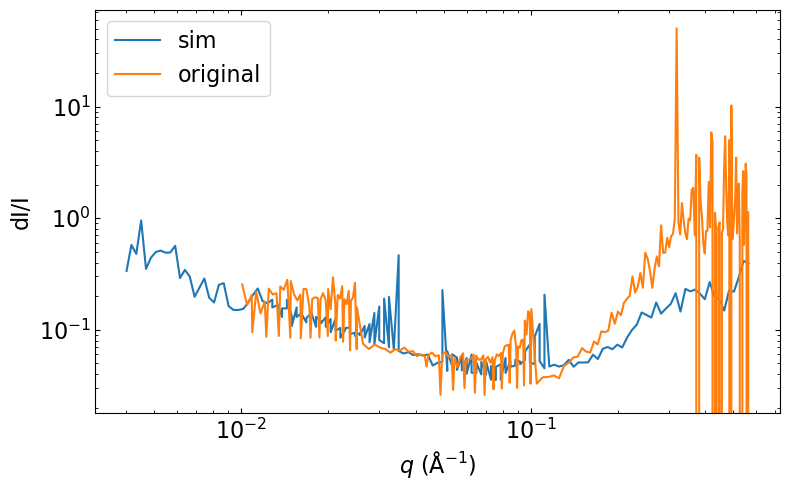

In [11]:
fig, ax = plt.subplots()

#i = 0
#while os.path.isfile('testdata.DAT'):
original = pandas.read_csv('bu/sim.dat', sep=' ', skip_blank_lines=True,comment='#')
simdata = pandas.read_csv('sim.dat', sep=' ', skip_blank_lines=True,comment='#')

ax.plot(simdata['Q'], (simdata['dI']/simdata['I']), label="sim")
ax.plot(original['Q'], (original['dI']/original['I']), label="original")

ax.legend(fontsize=16)
ax.set_ylabel("dI/I", fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=16)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=16)
ax.figure.set_size_inches(8, 5)
#ax.set_ylim(0, 0.25)
plt.tight_layout()
plt.savefig(store + "/uncertainty_comparison.png", facecolor="white")
plt.show()


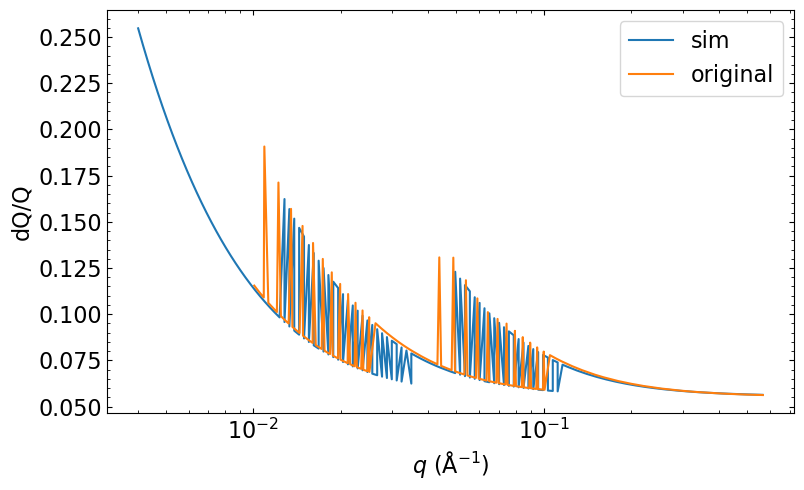

In [12]:
fig, ax = plt.subplots()

#i = 0
#while os.path.isfile('testdata.DAT'):
original = pandas.read_csv('bu/sim.dat', sep=' ', skip_blank_lines=True,comment='#')
simdata = pandas.read_csv('sim.dat', sep=' ', skip_blank_lines=True,comment='#')
ax.plot(simdata['Q'], (simdata['dQ']/simdata['Q']), label="sim")
ax.plot(original['Q'], (original['dQ']/original['Q']), label="original")

ax.legend(fontsize=16)
ax.set_ylabel("dQ/Q", fontsize=16)
ax.set_yscale('linear')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=16)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=16)
ax.figure.set_size_inches(8., 5)
#ax.set_ylim(0, 0.01)
plt.tight_layout()
plt.savefig(store + "/resolution_comparison.png", facecolor="white")
plt.show()


# Experimental Optimization

* Entropypar.dat contains a list of all fit parameters with a designation, whether they are marginal (d) or nuisance (i) parameters. This is followed by the parameter name, the initial parameter value, and the fit boundaries.
* Configuration parameters are given by a preceeding nxy, where x is the data set it applies to and y the configuration number. Not giving any xy makes this parameter apply to all configurations, as does passing a '*' in place of either x or y.
* Any number xy following a fit parameter indicates that this paramter is used for this particular dataset/configuration to determine the background (incoherent cross section). This typically applies to SLDs. The 'mode' argument for entropy.Entropy() then determines whether this is to be interpreted as an aqueous solvent or other.
* If three more numbers are given, this designates that an information content search over this parameter is performed (start, stop, step).
* A preceding f (fi or fd) at the beginning of the line indicates that the fit boundaries for such a search parameter are fixed (for example for volume fractions between 0 and 1), otherwise the fit boundary moves according to the varied parameter and the initally given fit boundaries.
* Any theta offset currently needs to have an initial value of zero. Otherwise refl1d will shift the q-values during data simulation with unexpected outcomes.
* If an instrumental parameter is specified for one data set, the instrumental parameter needs to be specified for all other datasets, as well.
* Data filenames are currently limited to sim.dat for a single file fit, or simx.dat, x = 0 ... n, for fits with multiple data sets

In [13]:
text = ['d _ _ radius_equatorial 11 5 17',
        'd _ _ radius_polar  20 17 35',
        'i _ _ volfraction  0.01 0.0001 0.02',
        'n * * lambda 6.21',
        'n * * differential_cross_section_buffer 0.059',
        'n * 0 sample_detector_distance 100',
        'n * 1 sample_detector_distance 400',
        'n * 2 sample_detector_distance 1300',
        'n * 0 source_sample_distance 387.6',
        'n * 1 source_sample_distance 850.05',
        'n * 2 source_sample_distance 1467',
        'n * 0 neutron_flux 9e5',
        'n * 1 neutron_flux 2e5',
        'n * 2 neutron_flux 1e5',
        'n * * source_aperture_radius 2.54',
        'n * * sample_aperture_radius 0.635',
        'n * * dlambda_lambda 0.136',
        'n * * beamstop_diameter 10.16',
        'n * 0 time 1600',
        'n * 1 time 3600',
        'n * 2 time 4400',
        'n * 0 beam_center_x 26.416',
        'n * * cuvette_thickness 0.2 0 0 0.02 4.1 0.1'
        ]

f=open('entropypar.dat', 'w')
f.writelines(line + '\n' for line in text)
f.close()

header_names = ['type', 'dataset', 'config.', 'parameter', 'value', 'l_fit', 'u_fit', 'l_opt', 'u_opt', 'step_opt']
df = pandas.read_csv('entropypar.dat', sep='\s+', header=None, names=header_names, skip_blank_lines=True, comment='#')
df

,type,dataset,config.,parameter,value,l_fit,u_fit,l_opt,u_opt,step_opt
0,d,_,_,radius_equatorial,11.000,5.0000,17.00,NaN,NaN,NaN
1,d,_,_,radius_polar,20.000,17.0000,35.00,NaN,NaN,NaN
2,i,_,_,volfraction,0.010,0.0001,0.02,NaN,NaN,NaN
3,n,*,*,lambda,6.210,NaN,NaN,NaN,NaN,NaN
4,n,*,*,differential_cross_section_buffer,0.059,NaN,NaN,NaN,NaN,NaN
5,n,*,0,sample_detector_distance,100.000,NaN,NaN,NaN,NaN,NaN
6,n,*,1,sample_detector_distance,400.000,NaN,NaN,NaN,NaN,NaN
7,n,*,2,sample_detector_distance,1300.000,NaN,NaN,NaN,NaN,NaN
8,n,*,0,source_sample_distance,387.600,NaN,NaN,NaN,NaN,NaN
9,n,*,1,source_sample_distance,850.050,NaN,NaN,NaN,NaN,NaN


In [14]:
entr = entropy.Entropy(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    mcmcburn=burn,
    mcmcsteps=steps,
    convergence=convergence,
    miniter=miniter,
    mode=mode,
    background_rule = None,
    bClusterMode=bClusterMode,
    bFetchMode=bFetchMode,
    calc_symmetric=bcalcsymmetric,
    upper_info_plotlevel=upper_info_plotlevel,
    plotlimits_filename=plotlimits_filename,
    slurmscript=script,
    configuration = configuration,
    keep_plots = keep_plots,
    optimizer = optimizer,
    show_support_points = show_support_points,
    qmin=qmin,
    qmax=qmax,
    qrangefromfile=qrangefromfile,
    t_total=t_total,
    jupyter_clear_output=True,
)

if RunOptimization:
    entr.run_optimization()

/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq


                                  par       value
0                   radius_equatorial      11.000
1                        radius_polar      20.000
2                         volfraction       0.010
3                              lambda       6.210
4   differential_cross_section_buffer       0.059
5            sample_detector_distance     100.000
6            sample_detector_distance     400.000
7            sample_detector_distance    1300.000
8              source_sample_distance     387.600
9              source_sample_distance     850.050
10             source_sample_distance    1467.000
11                       neutron_flux  900000.000
12                       neutron_flux  200000.000
13                       neutron_flux  100000.000
14             source_aperture_radius       2.540
15             sample_aperture_radius       0.635
16                     dlambda_lambda       0.136
17                  beamstop_diameter      10.160
18                               time    1600.000


/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: invalid value encountered in divide
  return (self.theory() - self.Iq) / self.dIq


# steps: 100, # draws: 3000
.background = 0.0005
.charge = 5
.concentration_salt = 0.15
.dielectconst = 71.08
.phi = 60
.phi_pd = 0
.phi_pd_n = 35
.phi_pd_nsigma = 3
.radius_effective = 20.75
.radius_effective_mode = 1
.radius_effective_pd = 0
.radius_effective_pd_n = 35
.radius_effective_pd_nsigma = 3
.radius_equatorial = 10.4284 in [5,17]
.radius_equatorial_pd = 0
.radius_equatorial_pd_n = 35
.radius_equatorial_pd_nsigma = 3
.radius_polar = 22.6071 in [17,35]
.radius_polar_pd = 0
.radius_polar_pd_n = 35
.radius_polar_pd_nsigma = 3
.scale = 1
.sld = 3.4
.sld_M0 = 0
.sld_mphi = 0
.sld_mtheta = 0
.sld_solvent = 6.4
.sld_solvent_M0 = 0
.sld_solvent_mphi = 0
.sld_solvent_mtheta = 0
.structure_factor_mode = 0
.temperature = 298
.theta = 60
.theta_pd = 0
.theta_pd_n = 35
.theta_pd_nsigma = 3
.up_angle = 0
.up_frac_f = 0
.up_frac_i = 0
.up_phi = 0
.volfraction = 0.0102934 in [0.0001,0.02]

[chisq=0.765(25), nllf=54.331]


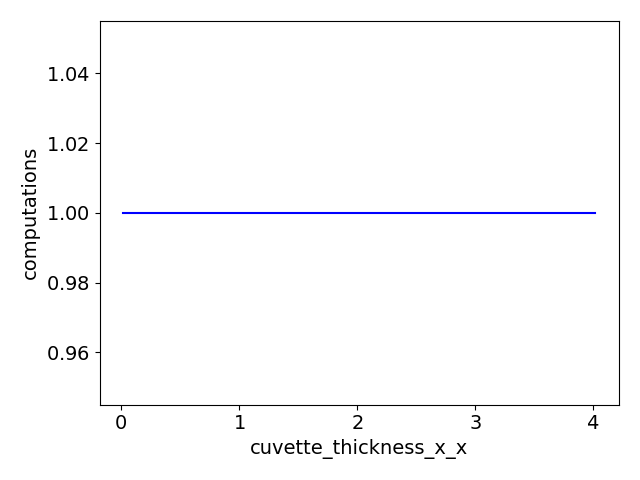

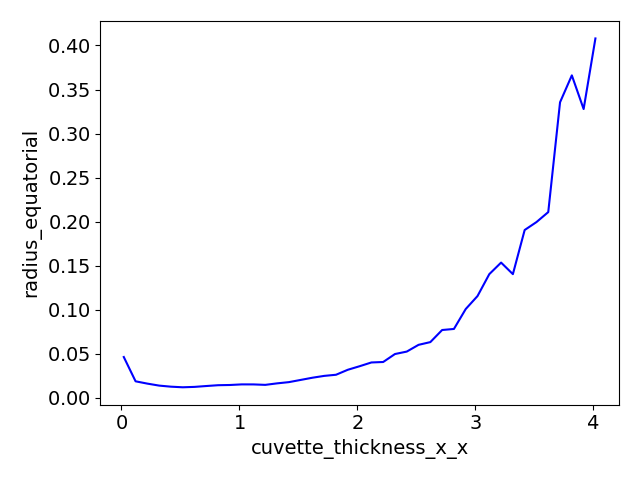

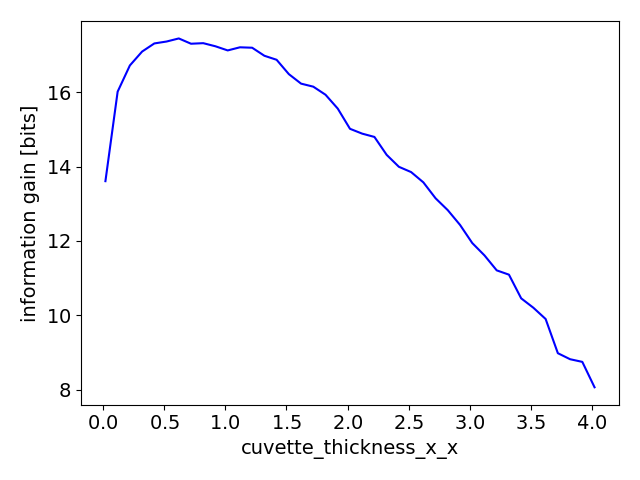

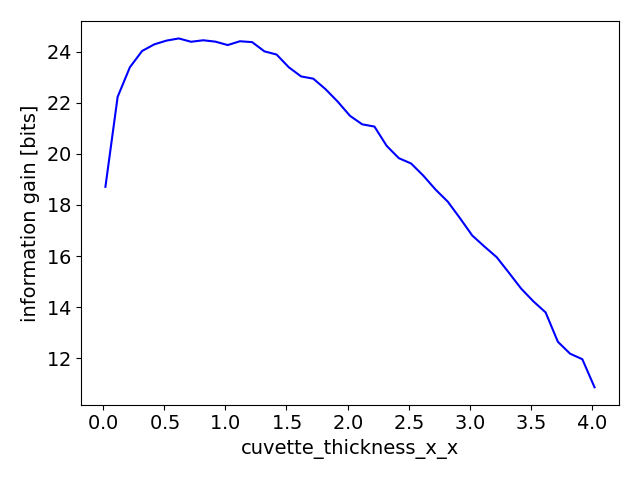

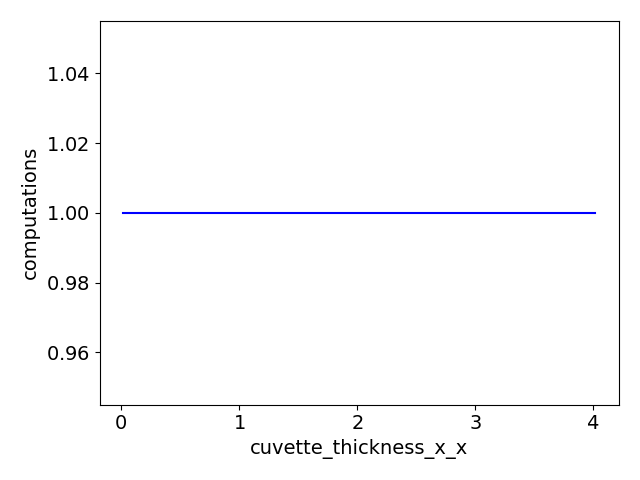

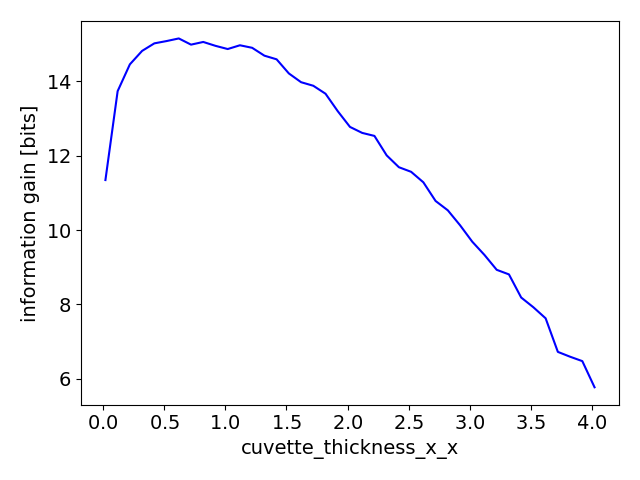

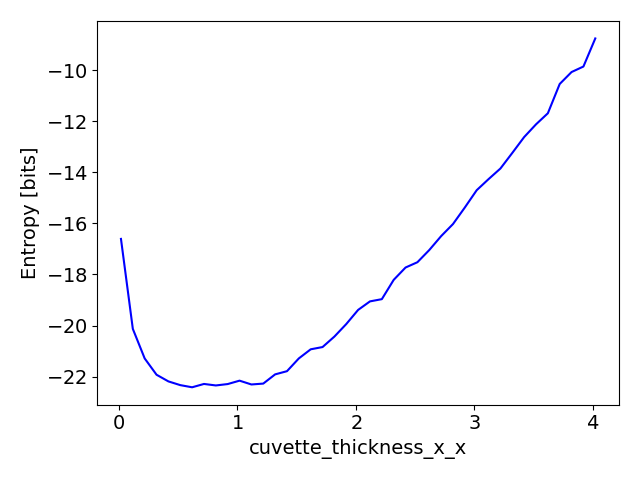

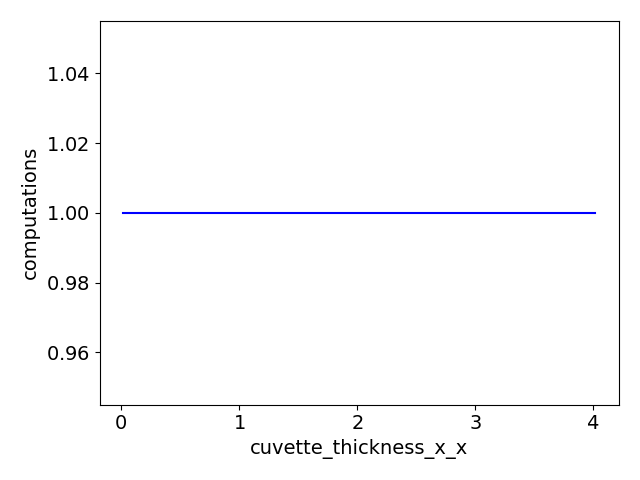

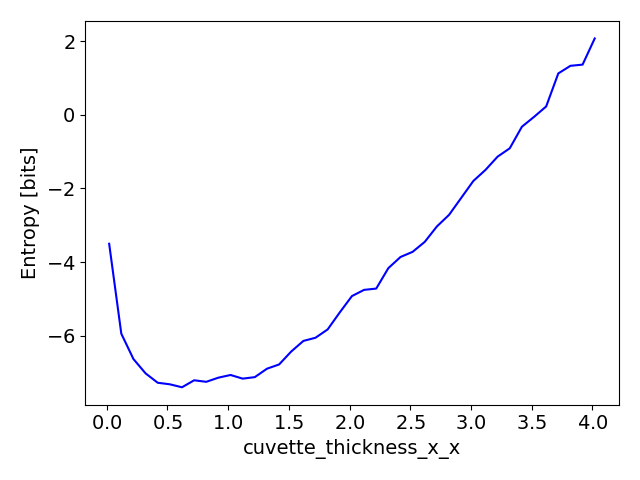

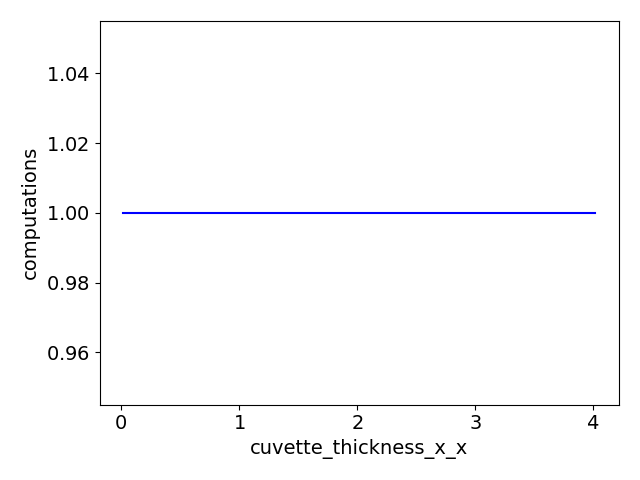

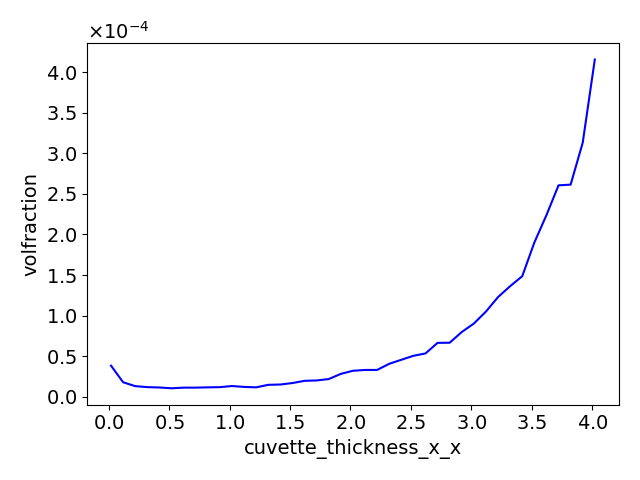

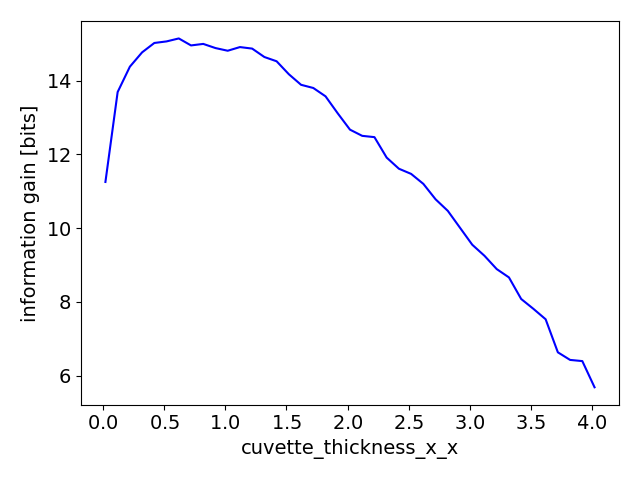

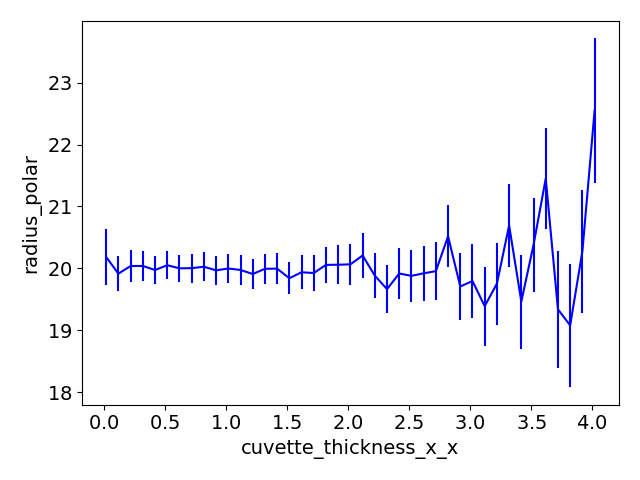

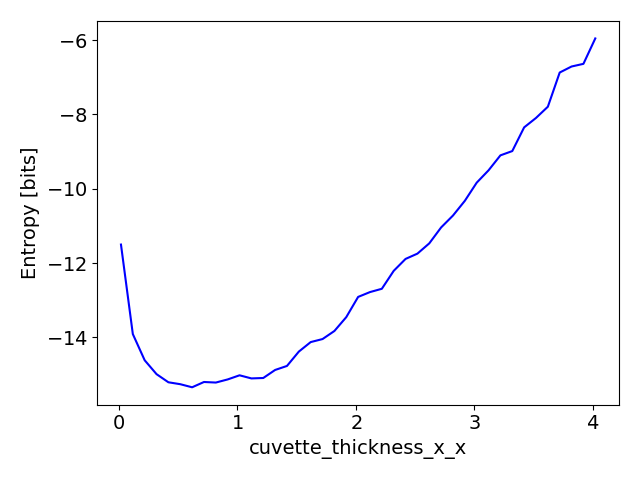

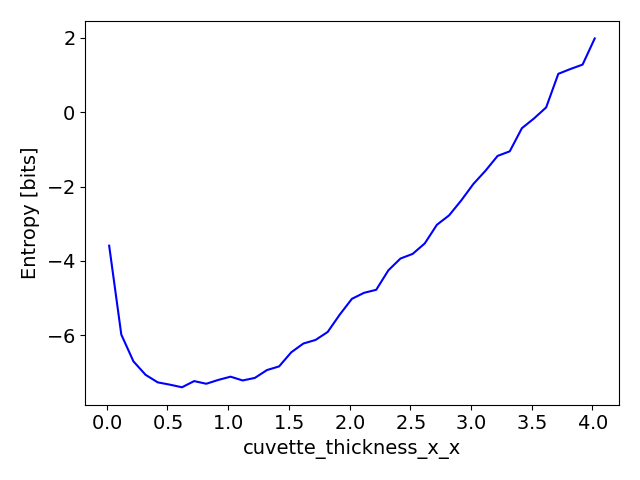

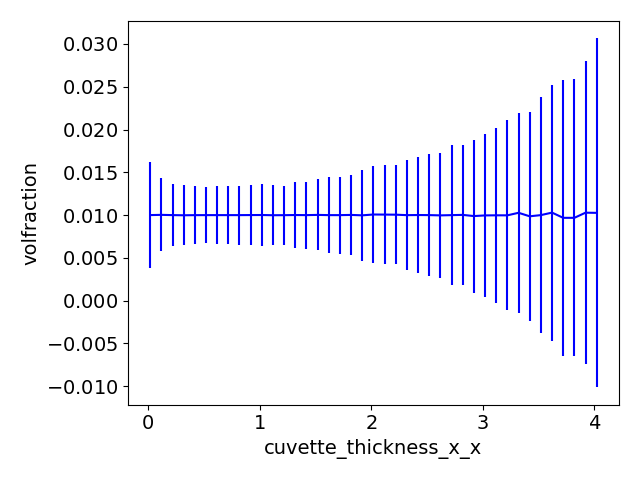

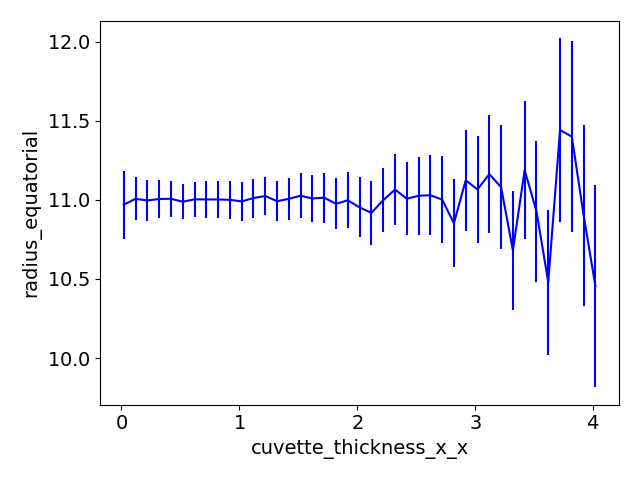

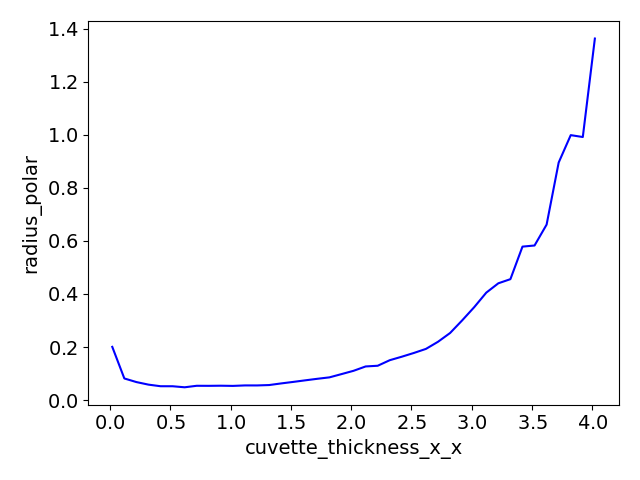

In [15]:
entr.plot_results()
from IPython.display import Image, display
import glob
from os import path
for file in glob.glob(path.join(setupdir, 'plots', "*.png")):
    display(Image(filename=file))